In [1]:
"""
File: tng_particles.py
Author: Matthew Ogden
Email: ogdenm12@gmail.com
Github: mbogden
Created: 2024-Apr-02

Description: 
    This code is designed to pull particle data from the IllustrisTNG Simulation. 
    It analyzes the particles, reassigned attribution, and performs statistical calculations

References:  
- [Add Illustris TNG ref]
- Code was written with the assistance of ChatGPT made by OpenAI.

"""


'\nFile: tng_particles.py\nAuthor: Matthew Ogden\nEmail: ogdenm12@gmail.com\nGithub: mbogden\nCreated: 2024-Apr-02\n\nDescription: \n    This code is designed to pull particle data from the IllustrisTNG Simulation. \n    It analyzes the particles, reassigned attribution, and performs statistical calculations\n\nReferences:  \n- [Add Illustris TNG ref]\n- Code was written with the assistance of ChatGPT made by OpenAI.\n\n'

In [2]:
# ================================ IMPORTS ================================ #
import os, argparse, h5py, pickle
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Illustris TNG import
import illustris_python as il

print("Imports Done")

# Global variables
SIM_DIR = '../sims.TNG/TNG50-1/output/'

# Am I currently writing this code?
buildEnv = True

Imports Done


In [3]:
# ================================ INPUT ARGUMENTS ================================ #

# Define argument parser function 
def initParser():
    
    parser = argparse.ArgumentParser()
    
    # Simulation Arguments
    parser.add_argument( '-s', '--simDir', default = '../sims.TNG/TNG50-1/output/',  type=str, \
                        help="Base directory for a single simulation on the IllustrisTNG servers.")   
    
    parser.add_argument( '-n', '--simName', default = 'TNG50-1',  type=str, \
                        help="Name for the simulation being worked on.")    

    # Function arguments
    parser.add_argument( '-f', '--function', default = 'None', type=str, \
                        help="Unqiue functions this program can execute from command line.")
    
    parser.add_argument( '-d', '--dataDir', default = 'data', type=str, \
                        help="Default location to store misc data files.")
    
    parser.add_argument('-ow', '--overwrite', action='store_true',
                        help="Overwrite output files? \
                        If false, will check if output file exists before beginning time-consuming tasks.")
    
    parser.add_argument( '-i', '--inputFile', type=str, \
                        help="Input file location.")
    
    parser.add_argument( '-o', '--outputFile', type=str, \
                        help="Output file location.")
    
    return parser

parser = initParser()
script_args = parser.parse_args()
print("Args: Defined")

Args: Defined


In [4]:
# ================================ MISC FUNCTIONS ================================ #

# A useful function I use for indented printing
def tabprint( printme, start = '\t - ', end = '\n' ):
    print( start + str(printme), end = end )

# Useful functions for constructing/deconstructing subhalo ids.
def generate_subhalo_id_raw(snap_num, subfind_id):
    # Convert input to integers in case they are passed as strings
    snap_num = int(snap_num)
    subfind_id = int(subfind_id)
    # Calculate the SubhaloIDRaw
    subhalo_id_raw = snap_num * 10**12 + subfind_id
    return subhalo_id_raw

def deconstruct_subhalo_id_raw(subhalo_id_raw):
    # Convert input to integer in case it is passed as a string
    subhalo_id_raw = int(subhalo_id_raw)
    # Extract SnapNum and SubfindID from SubhaloIDRaw
    snap_num = subhalo_id_raw // 10**12
    subfind_id = subhalo_id_raw % 10**12
    return (snap_num, subfind_id)

# Read simulation header file for misc info
def get_header_info( snap_num, get_info='dark_matter_particle_mass' ):
    
    # Read header to find standardized mass of dark matter particles
    with h5py.File(il.snapshot.snapPath(SIM_DIR, snap_num),'r') as f:
        header = dict(f['Header'].attrs)
        
        if get_info == 'dark_matter_particle_mass':            
            return header['MassTable'][1]
        elif get_info == 'redshift':
            return header['Redshift']
        else:
            print("UNKNOWN INFO REQUEST")

def explore_hdf5(file_path):
    """
    Recursively explore the contents of an HDF5 file.
    
    Parameters:
        file_path (str): The path to the HDF5 file to explore.
    
    Returns:
        dict: A dictionary containing information about the file's structure.
    """
    def recurse_through_group(group, prefix=''):
        """Helper function to recurse through groups and datasets."""
        info = {}
        for key, item in group.items():
            path = f"{prefix}/{key}" if prefix else key
            if isinstance(item, h5py.Dataset):
                # Gathering information for datasets
                info[path] = {
                    'type': 'Dataset',
                    'data_type': str(item.dtype),
                    'shape': item.shape,
                    'size': item.size,
                    'compression': item.compression
                }
            elif isinstance(item, h5py.Group):
                # Recurse into groups
                info[path] = {
                    'type': 'Group',
                    'contents': recurse_through_group(item, path)
                }
        return info

    # Open the HDF5 file
    with h5py.File(file_path, 'r') as file:
        return recurse_through_group(file)


----
# Get Particles and Subhalo Data
Given some inconsistencies within the Subhalo Catalog and it's values, (such as mass for the primary galaxy growing and secondary shrinking before they merged), I suspect how the subhalo algorythm calculates what particles belong to which subhalo is causing an issue. Specifically when two subhalos are close to one another, which tends to happen as they're about to collide.  So I'm going to do my own analysis of the raw particles.  

## Retrive Subhalo Catalog Information

In [5]:
# Simplify the info from the Subhalo Catalog
def get_subhalo_info( SubhaloIDRaw, simDir = SIM_DIR ):
    
    # Subhalo Keys
    fields = ['SubhaloID','NextProgenitorID','MainLeafProgenitorID','FirstProgenitorID','SubhaloGrNr',\
              'SubhaloIDRaw','SubhaloMass', 'RootDescendantID', 'SnapNum', 'DescendantID',\
              'SubhaloPos', 'SubhaloCM', 'SubhaloVel', 'SubhaloSpin', 'SubhaloHalfmassRad', ]

    snapnum, subhalo_id = deconstruct_subhalo_id_raw( SubhaloIDRaw )
    
    print(f"Obtaining Subhalo Catalog Info: {SubhaloIDRaw}")
    # Load Tree with desired fields
    tree = il.sublink.loadTree( simDir, snapnum, subhalo_id, fields=fields)
    
    # Only grab first row of data for each key
    
    info = {}
    
    for k in fields:
        info[k] = tree[k][0]
    
    # print( info )
    return info

if buildEnv and True:
    
    # Let's read from an information file
    targetLoc = 'data/TNG50-1-moi-info-67-75.csv'    
    assert os.path.exists( targetLoc ), f'Target information file not found: {targetLoc}'
        
    # Read potential tng targets file
    target_df = pd.read_csv( targetLoc )
    print( target_df.columns )
    print( 'All Targets: ', target_df.shape )
    
    # Find a single Merger of Interest (MOI) and snapshot I've been working with
    moi_id = 67000000350284 
    snapnum = 67    
    # moi_id = 67000000356635 
    # snapnum = 65
    moi_df = target_df[ target_df['moi_SubhaloIDRaw'] ==  moi_id ]
    print( 'Merger-of-Interest: ', moi_df.shape )
    
    # Sample primary and secondary galaxy ids for a particular snapshot
    snapshot_info = moi_df[ moi_df['snapnum'] == snapnum ]
    print( f"MOI Snapshot [{snapnum}] Info: {snapshot_info.shape}")
    id1 = snapshot_info['p_SubhaloIDRaw'].values[0]
    id2 = snapshot_info['s_SubhaloIDRaw'].values[0]
    
    # Dictionary to hold all the data
    pts = {}
    
    # Save data
    for i, tmp_id in enumerate( [ id1, id2 ] ):
        
        # init nested dictionaries
        pts[i] = {}
        pts[i]['calc'] = {}
        
        # Set ids and snapnum
        pts[i]['calc']['SubhaloIDRaw'] = tmp_id
        pts[i]['calc']['SnapNum'], pts[i]['calc']['SubhaloID'] = deconstruct_subhalo_id_raw( tmp_id )
        
        # Load subhalo catalog info
        pts[i]['subhalo'] = get_subhalo_info( pts[i]['calc']['SubhaloIDRaw'] )
        print( pts[i]['subhalo'] )


Index(['moi_SubhaloIDRaw', 'snapnum', 'p_acceleration', 'p_SubhaloIDRaw',
       's_SubhaloIDRaw', 'p_SubhaloMass', 's_SubhaloMass', 'p_SubhaloPos',
       's_SubhaloPos', 'p_SubhaloVel', 's_SubhaloVel', 'p_SubhaloSpin',
       's_SubhaloSpin', 'p_SubhaloHalfmassRad', 's_SubhaloHalfmassRad',
       'xy_projection', 'p_face_projection', 's_face_projection'],
      dtype='object')
All Targets:  (1957, 18)
Merger-of-Interest:  (20, 18)
MOI Snapshot [67] Info: (1, 18)
Obtaining Subhalo Catalog Info: 67000000350284
{'SubhaloID': 168010577, 'NextProgenitorID': 168021222, 'MainLeafProgenitorID': 168010641, 'FirstProgenitorID': 168010578, 'SubhaloGrNr': 119, 'SubhaloIDRaw': 67000000350284, 'SubhaloMass': 28.021235, 'RootDescendantID': 168010545, 'SnapNum': 67, 'DescendantID': 168010576, 'SubhaloPos': array([12290.1045, 21219.482 , 21532.25  ], dtype=float32), 'SubhaloCM': array([12309.062, 21232.86 , 21512.434], dtype=float32), 'SubhaloVel': array([-95.3405 , 188.69861,  73.1825 ], dtype=float

## Retrieve Subhalo Particles

In [6]:
def get_subhalo_particles(SubhaloIDRaw, get_part='all', basePath=SIM_DIR):
    """
    Load particle data for a given subhalo, handling cases where data may be missing by providing empty arrays.

    Args:
    SubhaloIDRaw (int): The raw subhalo ID.
    basePath (str): Base path to the simulation data.

    Returns:
    dict: A dictionary containing particle data for 'gas', 'stars', 'dm', and 'bh'.
    """
    def empty_array(fields):
        """ Helper function to create an empty structured array with specified fields. """
        empty_info = {}
        for f in fields:
            
            # Empty x y z array
            if f == 'Coordinates' or f == 'Velocities' or f == 'CenterOfMass':
                empty_info[f] = np.empty((0,3))
            
            # Empty value
            else:                
                empty_info[f] = np.empty(0)
                
        return empty_info

    # Decompose SubhaloIDRaw to get snapshot number and subhalo id
    snapnum, subhalo_id = deconstruct_subhalo_id_raw(SubhaloIDRaw)

    tng_part = {}
    
    # What particles am I loading?
    if get_part == 'all':
        particle_types = {
            #'gas': ['Coordinates', 'Velocities', 'ParticleIDs', 'Masses', 'CenterOfMass'],
            'gas': ['Coordinates', 'Velocities', 'ParticleIDs', 'Masses', ],
            'stars': ['Coordinates', 'Velocities', 'ParticleIDs', 'Masses', ],
            'dm': ['Coordinates', 'Velocities', 'ParticleIDs'],
            'bh': ['Coordinates', 'Velocities', 'ParticleIDs', 'BH_Mass']
        }
    elif get_part == 'id':
        particle_types = {
            'gas': ['ParticleIDs'],
            'stars': ['ParticleIDs'],
            'dm': ['ParticleIDs'],
            'bh': ['ParticleIDs']
        }
    elif get_part == 'stars':
        particle_types = {
            'stars': ['Coordinates', 'Velocities', 'ParticleIDs', 'Masses',],
        }
    elif get_part == 'photo':
        particle_types = {
            'stars': ['Coordinates', 'Velocities', 'ParticleIDs', 'Masses','GFM_StellarPhotometrics',],
        }
    else:
        raise AssertionError(f"Expecting 'all' or 'star' for get_part: {get_part}")
    
    type_to_num = {
        'gas':0,
        'dm':1,
        'stars':4,
        'bh':5,
    }

    # Attempt to load data for each particle type, handle failures by creating empty arrays
    for ptype, fields in particle_types.items():
        # print(f"TEST: {ptype} {fields} {type_to_num[ptype]}")
        try:
            tng_part[ptype] = il.snapshot.loadSubhalo(basePath, snapnum, subhalo_id, type_to_num[ptype], fields=fields)
        except Exception as e:
            print(f"Failed to load {ptype} data for SubhaloID {SubhaloIDRaw}: {e}")
            tng_part[ptype] = empty_array(fields)

    return tng_part
    
if buildEnv:
    
    for i in [0,1]:
        # Grab info
        ids = pts[i]['subhalo']['SubhaloIDRaw']        
        pts[i]['raw-data'] = get_subhalo_particles( ids )
        print(f"Subhalo: {ids}")
        for k in pts[i]['raw-data'].keys():    
            print( '\t - ', k, pts[i]['raw-data'][k]['Coordinates'].shape )
        
        # Verify star and id retrieval works too
        tmp_pts = get_subhalo_particles( ids, get_part='stars' )
        tmp_pts = get_subhalo_particles( ids, get_part='id' )
        print( type(tmp_pts) )

Subhalo: 67000000350284
	 -  gas (456466, 3)
	 -  stars (122296, 3)
	 -  dm (798199, 3)
	 -  bh (1, 3)
<class 'dict'>
Subhalo: 67000000350291
	 -  gas (19036, 3)
	 -  stars (30657, 3)
	 -  dm (15392, 3)
	 -  bh (1, 3)
<class 'dict'>


In [7]:
# Standardize particle data

def standardize_particles( tng_particles, snap_num, subhaloID = None):
    """
    Standardizes particle data for a given snapshot number.

    Inputs:
    - tng_particles (dict): Dictionary containing particle data for different types (e.g., gas, dark matter, stars).
    - snap_num (int): Snapshot number for which the particle data is being standardized.
    - subhaloID (int, optional): Subhalo ID to associate with the particles. Default is None.

    Outputs:
    - particles (ndarray): Array containing standardized particle data.
                           Columns:
                           0: x-coordinate (kpc/h)
                           1: y-coordinate (kpc/h)
                           2: z-coordinate (kpc/h)
                           3: x-velocity (km/s)
                           4: y-velocity (km/s)
                           5: z-velocity (km/s)
                           6: mass (10^10 M⊙/h)
                           
    - meta (ndarray): Array containing meta data for each particle.
                      Columns:
                      0: particle type (0: gas, 1: dark matter, 4: stars, 5: black hole)
                      1: particle ID (unique identifier for each particle)
                      2: subhalo ID (optional, associated subhalo ID if provided)
    """
    
    # Get mass of dark matter particles
    dm_part_mass = get_header_info( snap_num, 'dark_matter_particle_mass' )
    
    # Get total count of all particles
    n = 0
    for k in tng_particles:
        n += tng_particles[k]['Coordinates'].shape[0]
    
    # Initialize containers
    particles = np.zeros((n, 9))  # Row: [ x, y, z, v_x, v_y, v_z, mass, ]
    meta = np.zeros((n, 3)).astype(np.int64)  # Row: [ particle_type, particle_id, subhaloID ]
    
    # Reset n for convenience
    n = 0
    for k in tng_particles:
        
        #####   Physical Data   #####
        # Get paticle count 
        m = tng_particles[k]['Coordinates'].shape[0]
        #tabprint( f'Particles: {k}', start='\t' )
        
        # Store Position (kpc/h)  
        # if k == 'gas':  particles[n:n+m, 0:3] = tng_particles[k]['CenterOfMass']  # Center of Mass for gas
        # else:           particles[n:n+m, 0:3] = tng_particles[k]['Coordinates']  # Everyone else use coordinates
        # While COM is a better value for gas, not all gas particles have this value
        particles[n:n+m, 0:3] = tng_particles[k]['Coordinates']
        
        # Store Velocity (km/s)
        particles[n:n+m, 3:6] = tng_particles[k]['Velocities']        
        
        # Mass calculation.  (10^10 M⊙/h)
        if k == 'stars' or k == 'gas':  particles[n:n+m,6] = tng_particles[k]['Masses']  
        elif k == 'bh':            particles[n:n+m,6] = tng_particles[k]['BH_Mass']
        elif k == 'dm':            particles[n:n+m,6] = np.ones(m) * dm_part_mass
        
        #####   META DATA   #####
        # Particle Type.  Using Data Specs for Particle Type Int
        if k == 'gas':  meta[n:n+m,0] = 0 
        elif k == 'dm':  meta[n:n+m,0] = 1 
        elif k == 'stars':  meta[n:n+m,0] = 4
        elif k == 'bh':  meta[n:n+m,0] = 5
        
        # Particle ID
        meta[n:n+m,1] = tng_particles[k]['ParticleIDs']
        
        # Subhalo ID
        if subhaloID is not None:
            meta[n:n+m,2] = np.ones(m).astype(np.int64) * subhaloID

        # Increment starting index for next set of particles
        n += m
    
    return ( particles, meta )

def standardize_particles(tng_particles, snap_num, subhaloID=None):
    dm_part_mass = get_header_info(snap_num, 'dark_matter_particle_mass')
    n = sum(tng_particles[k]['Coordinates'].shape[0] for k in tng_particles)
    particles = np.zeros((n, 7))
    meta = np.zeros((n, 3), dtype=np.int64)
    n = 0
    for k in tng_particles:
        m = tng_particles[k]['Coordinates'].shape[0]
        particles[n:n + m, 0:3] = tng_particles[k]['Coordinates']
        particles[n:n + m, 3:6] = tng_particles[k]['Velocities']
        particles[n:n + m, 6] = tng_particles[k]['Masses'] if k in ['stars', 'gas'] else (tng_particles[k]['BH_Mass'] if k == 'bh' else np.full(m, dm_part_mass))
        meta[n:n + m, 0] = {'gas': 0, 'dm': 1, 'stars': 4, 'bh': 5}[k]
        meta[n:n + m, 1] = tng_particles[k]['ParticleIDs']
        if subhaloID is not None:
            meta[n:n + m, 2] = subhaloID
        n += m
    return particles, meta


if buildEnv and True:
    
    for i in [0,1]:
        ids = pts[i]['calc']['SubhaloIDRaw']
        snapnum = pts[i]['calc']['SnapNum']
        pts[i]['calc']['SubhaloPos'] = pts[i]['raw-data']['bh']['Coordinates'][0]

        print(f"Standardizing Subhalo: {ids}")
        pts[i]['data'], pts[i]['meta'] = standardize_particles( pts[i]['raw-data'], snapnum, ids )
        tabprint( f"Particles / Meta: {pts[i]['data'].shape} / {pts[i]['meta'].shape}" )



Standardizing Subhalo: 67000000350284
	 - Particles / Meta: (1376962, 7) / (1376962, 3)
Standardizing Subhalo: 67000000350291
	 - Particles / Meta: (65086, 7) / (65086, 3)


# Subhalo plots

Let's plot some particles and see how "good" the subhalo calculations are.

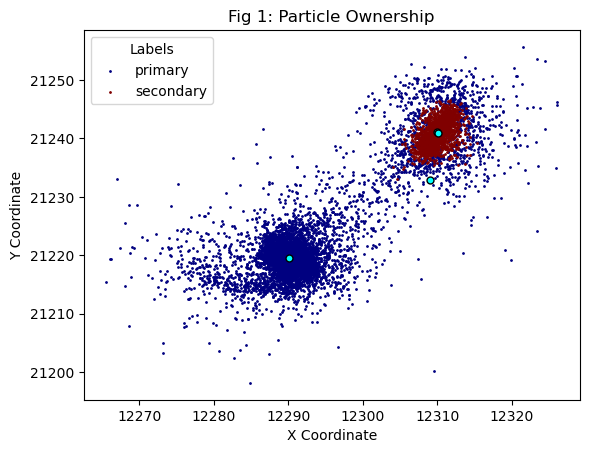

In [8]:
def xy_scatter(xy_data, labels = None, large_dots = None, title="Scatter Plot with Labels", std_dev=3):
    """
    Plots a scatter plot with labeled points having unique colors and large, unlabeled dots.
    Ignores points that are more than 4 standard deviations from the mean in either dimension.

    Args:
    xy_data (np.ndarray): An N x 2 array of xy coordinates.
    labels (np.ndarray): An N-sized array of labels for each point in xy_data.
    large_dots (np.ndarray): An M x 2 array of xy coordinates for large, unlabeled dots.
    """
    
    # If no labels given, just give them all 0
    if labels is None: labels = np.zeros( xy_data.shape[0] )
    
    # Ensure input integrity
    assert xy_data.shape[0] == labels.shape[0], "xy_data and labels must have the same length"
    assert xy_data.shape[1] >= 2, "xy_data should be N x 2 in shape"
    
    # Calculate the mean and standard deviation.  To ignore plotting outlyers.
    mean_xy = np.mean(xy_data, axis=0)
    std_xy = np.std(xy_data, axis=0)

    # Create masks for data within 4 standard deviations
    within_bounds = np.all(np.abs(xy_data - mean_xy) <= std_dev * std_xy, axis=1)

    # Filter xy_data and labels based on the mask
    filtered_xy_data = xy_data[within_bounds]
    filtered_labels = labels[within_bounds]

    # Create a plot
    fig, ax = plt.subplots()

    # Generate a color map from labels
    unique_labels = np.unique(filtered_labels)
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))  # Using jet colormap, can change to any
    label_color_dict = dict(zip(unique_labels, colors))

    # Plotting labeled points
    for label in unique_labels:
        indices = filtered_labels == label
        ax.scatter(filtered_xy_data[indices, 0], filtered_xy_data[indices, 1], label=str(label),
                   color=label_color_dict[label], s=1)  # s is the size of the normal dots

    # Plotting large, unlabeled dots

    if large_dots is not None:
        assert large_dots.shape[1] >= 2, "large_dots should be M x 2 in shape"
        ax.scatter(large_dots[:, 0], large_dots[:, 1], color='cyan', s=25, edgecolor='black', linewidth=1)  # s is the size of the large dots

    # Optional: Add a legend
    ax.legend(title="Labels")

    # Set titles and labels
    ax.set_title(title)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")

    # Show plot
    plt.show()


if buildEnv: 
    
    # Grab relevenat info
    id1 = pts[0]['subhalo']['SubhaloIDRaw']
    id2 = pts[1]['subhalo']['SubhaloIDRaw']
    sub_pts1 = pts[0]['raw-data']['stars']['Coordinates'][::10]
    sub_pts2 = pts[1]['raw-data']['stars']['Coordinates'][::10]
    
    py_pts = np.vstack(( sub_pts1, sub_pts2 ))
    labels = [ 'primary' for _ in range( sub_pts1.shape[0] ) ]
    labels.extend( [ 'secondary' for _ in range( sub_pts2.shape[0] ) ] )
    labels = np.array( labels )
    sig_pts = np.vstack(( pts[0]['raw-data']['bh']['Coordinates'][0], pts[1]['raw-data']['bh']['Coordinates'][0] )) # Add Supermassive Black Hole positions
    sig_pts = np.vstack(( sig_pts, pts[0]['subhalo']['SubhaloCM'], pts[1]['subhalo']['SubhaloCM'] )) # Add Center of mass positions
    
    # Grab only stars

    xy_scatter( py_pts, labels, sig_pts, title = 'Fig 1: Particle Ownership')


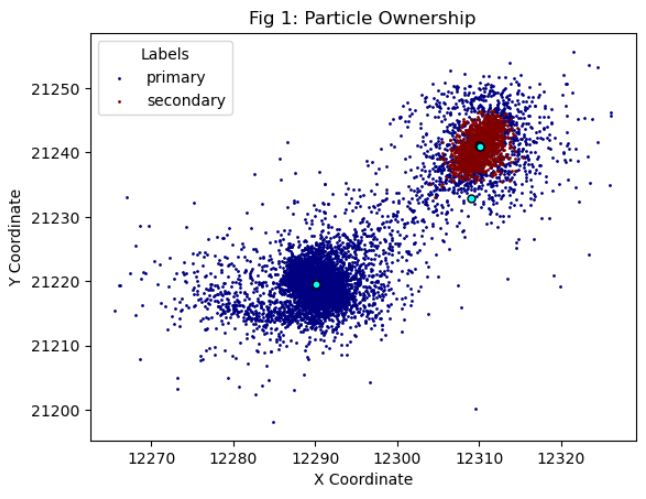

Noting Fig 1 above, many particles I would say belong to the secondary galaxy, have instead been attributed to the primary galaxy.  This confirmes my suspicious of particle attribution behaving differently than I wish during encounter events.  Thus, the subhalo catalog values are not the values I want for my research.

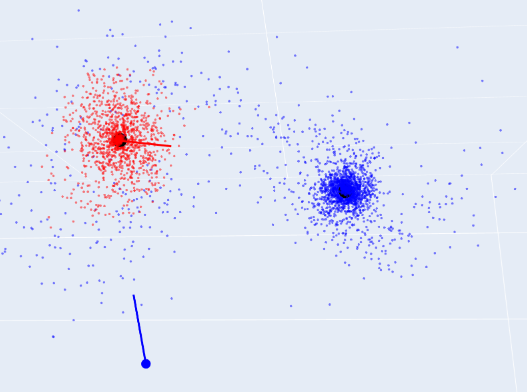

Looking at Fig 2 below, we can see some inconsistencies with the primary Center of Mass and spin directions. The secondary COM and spin appear correct, the COM being in the galactic center and spin pointing perpendicular to the disk.  However, the primary's COM is far from its galactic center and spin is not perpendicular to the galactic disk.  I suspect this is because 1) the FOF algorithm used to define subhalo ownership is prematuring assigning particles that were the secondary's to the primary. And 2) I suspect there may be other subhalos/galaxies nearby that are not shown in Figure 2.  Analysis of a larger view showned a distinct cloud of dark matter particles to one side.

In [9]:
def interactive_3d_scatter(xyz_data, labels, sig_pts = None, vector_list = None, title="Scatter Plot with Labels", std_dev=4):
    """
    Plots an interactive 3D scatter plot with labeled points having unique colors and large, unlabeled dots.

    Args:
    xyz_data (np.ndarray): An N x 3 array of xyz coordinates.
    labels (np.ndarray): An N-sized array of labels for each point in xyz_data.
    sig_pts (np.ndarray): An M x 3 array of xyz coordinates for significant positions.
    vector_list (np.ndarray): An M x 3 array of xyz dynamics for vectors of interest originating from sig_pts.
    title (str): Title of the plot.
    """
    # Ensure input integrity
    assert xyz_data.shape[0] == labels.shape[0], "xyz_data and labels must have the same length"
    assert xyz_data.shape[1] >= 3, "xyz_data should be N x 3 in shape"
    
    # Calculate the mean and standard deviation.  To ignore plotting outlyers.
    mean_xyz = np.mean(xyz_data, axis=0)
    std_xyz = np.std(xyz_data, axis=0)

    # Create masks for data within 4 standard deviations
    within_bounds = np.all(np.abs(xyz_data - mean_xyz) <= std_dev * std_xyz, axis=1)

    # Filter xy_data and labels based on the mask
    xyz_data = xyz_data[within_bounds]
    labels = labels[within_bounds]

    # Create a Plotly figure
    fig = go.Figure()

    # Generate a color map from labels
    unique_labels = np.unique(labels)
    colors = [f"rgba({r}, {g}, {b}, {alpha})" for r, g, b, alpha in
              (np.random.rand(len(unique_labels), 4) * 255).astype(int)]
    label_color_dict = dict(zip(unique_labels, colors))

    # Plotting labeled points
    for label in unique_labels:
        indices = labels == label
        fig.add_trace(go.Scatter3d(
            x=xyz_data[indices, 0], y=xyz_data[indices, 1], z=xyz_data[indices, 2],
            mode='markers',
            marker=dict(size=2, color=label_color_dict[label]),
            name=str(label)
        ))

    # Plotting large, unlabeled dots
    if sig_pts is not None:
        assert sig_pts.shape[1] >= 3, "large_dots should be M x 3 in shape"
        fig.add_trace(go.Scatter3d(
            x=sig_pts[:, 0], y=sig_pts[:, 1], z=sig_pts[:, 2],
            mode='markers',
            marker=dict(size=12, color='black'),
            name='Significant_Points'
        ))
        
    # Add vectors if given
    if vector_list is not None:
        # Assume vector list must work with signicant points
        assert sig_pts.shape[0] == vector_list.shape[0], "vector list must match size of significant points"
        assert sig_pts.shape[1] == 3, "vector_list should be M x 3 in shape"

        for i in range(len(sig_pts)):
            normalized_vector = vector_list[i] / np.linalg.norm(vector_list[i]) * std_xyz.mean() 
            endpoint = sig_pts[i] + normalized_vector
            fig.add_trace(go.Scatter3d(
                x=[sig_pts[i, 0], endpoint[0]],
                y=[sig_pts[i, 1], endpoint[1]],
                z=[sig_pts[i, 2], endpoint[2]],
                mode='lines+markers',
                line=dict(width=5),
                marker=dict(size=2, color='red'),
                name='Vector {}'.format(i)
            ))

    # Update plot layout
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X Coordinate',
            yaxis_title='Y Coordinate',
            zaxis_title='Z Coordinate',
            # aspectmode='cube'  # This makes x, y, z scales equal
        ),
        legend_title="Labels",

        width=1600,
        height=800,
    )

    # Show plot
    fig.show()

if buildEnv and False:

    # interactive_3d_scatter( star_pts[::100], labels[star_mask][::100], f_centroids[:], title = 'Weighted K-Means Clusting: k=2')
    
    py_pts = np.vstack(( sub_pts1, sub_pts2 ))
    labels = [ 'primary' for _ in range( sub_pts1.shape[0] ) ]
    labels.extend( [ 'secondary' for _ in range( sub_pts2.shape[0] ) ] )
    labels = np.array( labels )
    # sig_pts = np.vstack(( pts[0]['raw-data']['bh']['Coordinates'][0], pts[1]['raw-data']['bh']['Coordinates'][0] )) # Add Supermassive Black Hole positions
    sig_pts = np.vstack(( pts[0]['subhalo']['SubhaloCM'], pts[1]['subhalo']['SubhaloCM'] )) # Add Center of mass positions
    vectors = np.vstack(( pts[0]['subhalo']['SubhaloSpin'], pts[1]['subhalo']['SubhaloSpin'] ))
    
    interactive_3d_scatter( py_pts, labels, sig_pts, vectors, title = 'Plot of galaxies and Spins around Center of Mass')


-----
# Reassign Particle Ownership via Historic Association 
Now that we've proven that the primary galaxy seems to have "taken" quite a few particles that once belonged to the secondary particles, I'd like to reassign the particles.  But how?  I noticed Particle IDs are given to each particle and these are a constant value over the simulation.  Therefore I suspect I can look backwards in time to see if a particle has been in the primary or secondary galaxy more often.  Then reassign ownership based on which galaxy it has spent more time in.  

## (Deprecated) Get particles over many snapshots.
Turns out, I run out of memory if I try to load all snapshot particles at once.

In [10]:
#####    DEPRECATED   #####
def DEPRECATED_get_moi_particle_data( moi_df, overwrite = False ):
    
    # Get MOI ids
    moi_id = moi_df['moi_SubhaloIDRaw'].unique()
    
    # This function only handles one merger of interest (MOI) at a time.
    assert len(moi_id) == 1
    
    # grab moi
    moi_id = moi_id[0]
    print( f'Getting Particles for Merger: {moi_id}' )
    
    # location to save info
    moi_loc = f"data/particle-data-moi-{moi_id}.pickle"
    
    # Load particles from pickle file if available 
    if os.path.exists( moi_loc ) and not overwrite:        
        print(f"Reading MOI particle file: {moi_loc}")
        with open( moi_loc , 'rb') as file:
            pts = pickle.load( file )
    
    # Else create particle dictionary from scratch
    else:
        pts = {}

        # Iterate using iterrows
        c = 0
        n = moi_df.shape[0]
        for index, row in moi_df.iterrows():

            # Print progress
            tabprint( f"{c}/{n}" )
            c += 1

            # Pull important info
            snapnum = row['snapnum']
            p_id = row['p_SubhaloIDRaw']
            s_id = row['s_SubhaloIDRaw']

            pts[snapnum] = { 0:{}, 1:{} }  # 0 = primary, 1 = secondary

            # Pull Catalog data
            pts[snapnum][0]['subhalo'] = get_subhalo_info( p_id )
            pts[snapnum][1]['subhalo'] = get_subhalo_info( s_id )

            # Pull TNG Raw Particle Data
            try:
                # Retrieve particles
                pts[snapnum][0]['raw-data'] = get_subhalo_particles( p_id )
                pts[snapnum][1]['raw-data'] = get_subhalo_particles( s_id )

                # Access all fields to ensure data exists
                for i in [0,1]:
                    for k in pts[snapnum][i]['raw-data'].keys():
                        tmp = ( '\t - ', k, pts[snapnum][i]['raw-data'][k]['Coordinates'].shape  )

            # If set of particles are missing, just ignore that set
            except:
                print(f"Failed to pull particle data: {pts[snapnum][0]['subhalo']['SubhaloIDRaw']}")
                del pts[snapnum]
                continue
                
        # End moi_df.iterrows() loop
                
        # Save particles.
        # Open a file for writing. The 'wb' parameter denotes 'write binary'
        with open(moi_loc, 'wb') as file:
            pickle.dump(pts, file)
        print(f"MOI particles have been saved: {moi_loc}")

    # Iterate back through snapshots and standardize particles
    # This prevents having to pickel twice the needed amount of data.
    for snapnum in pts.keys():
        
        # Standardize particles 
        tmp, data0, meta0 = standardize_particles( pts[snapnum][0]['raw-data'], snapnum, 0 ) # 0 for primary
        tmp, data1, meta1 = standardize_particles( pts[snapnum][1]['raw-data'], snapnum, 1 ) # 1 for secondary

        # Combine datasets
        pts[snapnum]['data'] = np.vstack((data0, data1)) 
        pts[snapnum]['meta'] = pd.DataFrame( np.vstack((meta0, meta1)), columns=[ 'particle_type', 'particle_id', 'subhalo_ps_label'])

    return pts

if buildEnv and False: 
    moi_data = get_moi_particle_data( moi_df )
    print( f"Moi Snapshots: {list(moi_data.keys())}" )
    

## Temporal Ownership
Since the particle ID is a constant value over the simulation, then I can look backwards in time to see if a particle has been in the primary or secondary galaxy.  Let's look at each particle and decide which galaxy it belongs to based on which galaxy it's spent more time in.

In [11]:
def get_data( sr, type='all' ):

    # Get current info
    pid = sr['p_SubhaloIDRaw']
    sid = sr['s_SubhaloIDRaw']
    snapnum = sr['snapnum']
        
    # Get particles and standardize
    pdata, pmeta = standardize_particles( get_subhalo_particles( pid ), snapnum, 0 )
    sdata, smeta = standardize_particles( get_subhalo_particles( sid ), snapnum, 1 )
    
    data = np.vstack(( pdata, sdata ))
    meta = np.vstack(( pmeta, smeta ))
    
    return ( data, meta )
    

# Expecting a single row (Series) from a DataFrame
def get_meta( sr ):

    # Get current info
    pid = sr['p_SubhaloIDRaw']
    sid = sr['s_SubhaloIDRaw']
    snapnum = sr['snapnum']
    
    # Get particle ids
    ppts = get_subhalo_particles( pid, get_part='id' )
    spts = get_subhalo_particles( sid, get_part='id' )
    
    # Quick standardize for meta data of particles
    def std_meta( pts, subhalo_id ):
        
        # Get size of total meta array
        n = 0
        for k in pts:
            n += pts[k].shape[0]
            
        # Create
        meta = np.zeros((n, 3)).astype(np.int64)  # Row: [ particle_type, particle_id, subhaloID ]
        
        # Transfer meta data
        c = 0
        for k in pts:
            m = pts[k].shape[0]        
            meta[c:c+m,1] = pts[k]
            meta[c:c+m,2] = np.ones(m).astype(np.int64) * subhalo_id
            c += m

        return meta           
    
    # Create container for meta
    pmeta = std_meta( ppts, 0 )
    smeta = std_meta( spts, 1 )

    # combine data
    allmeta = np.vstack(( pmeta, smeta ))   

    return allmeta

def calculate_historic_affiliation( moi_df, current_snapnum, snapshots_back=10, overwrite = False):
    """
    Calculate the counts of particle affiliations to primary and secondary galaxies over a specified number of snapshots.

    Args:
        moi_pts (dict): A dictionary containing snapshot data indexed by snapshot numbers. Each entry should have a
                        'meta' subdictionary with 'particle_id' and 'subhalo_ps_label' arrays.
        current_snapnum (int): The snapshot number from which to start the backward counting.
        snapshots_back (int, optional): Number of snapshots to go back from the current snapshot. Defaults to 10.

    Returns:
        tuple: Two numpy arrays containing counts of affiliations to primary and secondary galaxies respectively.
    """
    
    # Get MOI ids
    tmp_ids = moi_df['moi_SubhaloIDRaw'].unique()
    
    # Assert this function only handles one merger of interest (MOI) at a time.
    assert len(tmp_ids) == 1
    
    # grab moi for current snapnum
    moi_id = moi_df[ moi_df['snapnum'] == current_snapnum ].iloc[0]['p_SubhaloIDRaw']
    print( f'Getting Particles for Snaphot / Merger: {current_snapnum} / {moi_id}' )
    
    # location to save standardized particles and meta data.
    label_loc = f"data/historic-labels-{snapshots_back}-{moi_id}.txt"
    
    # Load particles from pickle file if available 
    if os.path.exists( label_loc ) and not overwrite:
        print(f"Reading historical label file: {label_loc}")
        labels = np.loadtxt( label_loc )
        return labels
    
    
    # Determine the minimum snapshot number to consider based on the provided range
    min_snapnum = max(current_snapnum - snapshots_back, min(moi_df['snapnum']))
    
    # Get current snapshot particle IDs
    c_df = moi_df[ moi_df['snapnum'] == current_snapnum ].iloc[0]
    meta = get_meta( c_df )
    
    curr_ids = meta[:,1]
    id_to_index = {id_: i for i, id_ in enumerate(curr_ids)}
    
    # Remove after loading only necessary info
    del meta
    
    # Compile IDs and labels from past snapshots
    print("Getting all particle ids and labels")
    past_data = {}
    
    for snapnum in range(current_snapnum, min_snapnum - 1, -1):
        tabprint(f"{snapnum} : {current_snapnum} --> {min_snapnum}", end='\r')
        
        # Get particles + meta
        tmp_df = moi_df[ moi_df['snapnum'] == snapnum ].iloc[0]
        tmp_meta = get_meta( tmp_df )

        # Get label
        tmp_ids = tmp_meta[:,1]
        tmp_labels = tmp_meta[:,2]
        past_data[snapnum] = {id_: label for id_, label in zip(tmp_ids, tmp_labels)}
        
        
        
    print( 'Labels retrieved')

    # Process each snapshot data using precompiled past_data
    print("Iterating through snapshots")
    
    primary_count = np.zeros(len(curr_ids))
    secondary_count = np.zeros(len(curr_ids))
    
    for snapnum, pdata in past_data.items():
        print( f"Row: {snapnum} Min: {min_snapnum}", end='\r' )
        for pid, label in pdata.items():
            if pid in id_to_index:
                idx = id_to_index[pid]
                if label == 0:
                    primary_count[idx] += 1
                elif label == 1:
                    secondary_count[idx] += 1
       
    # Slight bias towards secondary since primary is greedy
    historic_label = np.where( primary_count > secondary_count, 0, 1)  
    
    # Save results
    np.savetxt( label_loc, historic_label )
    
    return historic_label
def calculate_historic_affiliation(moi_df, current_snapnum, snapshots_back=10, overwrite=False):
    """
    Calculate the counts of particle affiliations to primary and secondary galaxies over a specified number of snapshots.

    Args:
        moi_df (pd.DataFrame): DataFrame containing merger of interest (MOI) data.
        current_snapnum (int): The snapshot number from which to start the backward counting.
        snapshots_back (int, optional): Number of snapshots to go back from the current snapshot. Defaults to 10.

    Returns:
        np.ndarray: Array containing the historic affiliations of particles.
    """
    
    # Get MOI ids
    tmp_ids = moi_df['moi_SubhaloIDRaw'].unique()
    
    # Assert this function only handles one merger of interest (MOI) at a time.
    assert len(tmp_ids) == 1
    
    # Grab moi for current snapnum
    moi_id = moi_df[moi_df['snapnum'] == current_snapnum].iloc[0]['p_SubhaloIDRaw']
    print(f'Getting Particles for Snapshot / Merger: {current_snapnum} / {moi_id}')
    
    # Location to save standardized particles and meta data.
    label_loc = f"data/historic-labels-{snapshots_back}-{moi_id}.txt"
    
    # Load particles from pickle file if available 
    if os.path.exists(label_loc) and not overwrite:
        print(f"Reading historical label file: {label_loc}")
        labels = np.loadtxt(label_loc)
        return labels
    
    # Determine the minimum snapshot number to consider based on the provided range
    min_snapnum = max(current_snapnum - snapshots_back, min(moi_df['snapnum']))
    
    # Get current snapshot particle IDs
    c_df = moi_df[moi_df['snapnum'] == current_snapnum].iloc[0]
    meta = get_meta(c_df)
    
    curr_ids = meta[:,1]
    id_to_index = {id_: i for i, id_ in enumerate(curr_ids)}
    
    # Remove after loading only necessary info
    del meta
    
    # Initialize counts
    primary_count = np.zeros(len(curr_ids))
    secondary_count = np.zeros(len(curr_ids))
    
    print("Generating Historical Counts")
    
    # Iterate backwards through snapshots
    for snapnum in range(current_snapnum, min_snapnum - 1, -1):
        print(f"Current {snapnum} : {current_snapnum} --> {min_snapnum}", end='\r')
        
        # Get particles + meta
        tmp_df = moi_df[moi_df['snapnum'] == snapnum].iloc[0]
        tmp_meta = get_meta(tmp_df)
        
        # Update counts based on past snapshot labels
        tmp_ids = tmp_meta[:,1]
        tmp_labels = tmp_meta[:,2]
        for pid, label in zip(tmp_ids, tmp_labels):
            if pid in id_to_index:
                idx = id_to_index[pid]
                if label == 0:
                    primary_count[idx] += 1
                elif label == 1:
                    secondary_count[idx] += 1
    
    # Calculate historic affiliation
    historic_label = np.where(primary_count > secondary_count, 0, 1)
    
    # Save results
    np.savetxt(label_loc, historic_label)
    
    return historic_label

if buildEnv:
    hist_labels = calculate_historic_affiliation( moi_df, snapnum, overwrite=True )
    print( '\nDone' )

Getting Particles for Snapshot / Merger: 67 / 67000000350284
Processing snapshots
Done 67 --> 57


In [ ]:

if buildEnv:
    
    pid = 67000000350284
    row = moi_df[ moi_df['p_SubhaloIDRaw'] == pid ].iloc[0]
    print( type(row ) )
    data, meta = get_data( row )
    
    # Get star particles to plot  
    star_mask = meta[:,0] == 4
    
    # Plot particles
    xy_scatter( data[star_mask,:][::10], hist_labels[star_mask][::10], title = 'Fig 3: Historic Affiliation Labels')

In [13]:
if buildEnv and False: 
    interactive_3d_scatter( moi_data[snapnum]['data'][star_mask,:][::10], time_labels[star_mask][::10], centers, title = 'Fig 4: Historic Labels')

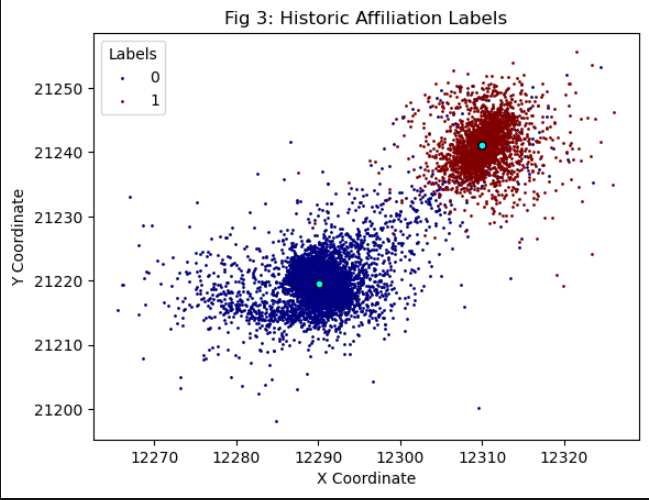

Yay!  Based on Fig 3, I'm much happier with using the historical affiliation to reassign new labels.  However, now that we have new labels, we need to calculate new statistics for each galaxy.

-----
# Comparing Subhalo Catalog to Particle Values

To validate whether my calculated particle dynamics are valid (correct units, methodology, locations, etc) I want to confirm many of my calculated values match those of the subhalo catalog.  Then I can get data for the new particles.

## Comparing Subhalo Catalog to my Calculations
Here's a convenient function to print and compare subhalo catalog values to the values i calculated.

In [14]:
# Write function to verify if calculated values are close to subhalo catalog values
def compare_data( pts, k ):
    for i in [0,1]:
        print('')
        subhalo = pts[i]['subhalo']
        calc = pts[i]['calc']
        print( k, subhalo['SubhaloIDRaw'] )
        tabprint( f'Subhalo: {subhalo[k]}' )
        tabprint( f'Calc: {calc[k]}' )
        percent_diff = 100 * np.sum(np.abs(subhalo[k] - calc[k])) / np.sum(np.abs(subhalo[k]))
        tabprint( "%% Diff: %.1e" % percent_diff)

if buildEnv:
# Check values 
    sanity_keys = [ 'SubhaloPos' ]
    print( "Postion: SubhaloPos (Particle with least potential) vs Black Hole Position: ")    
    compare_data( pts, sanity_keys[0] )

Postion: SubhaloPos (Particle with least potential) vs Black Hole Position: 

SubhaloPos 67000000350284
	 - Subhalo: [12290.1045 21219.482  21532.25  ]
	 - Calc: [12290.11035686 21219.49030532 21532.25694501]
	 - % Diff: 3.8e-05

SubhaloPos 67000000350291
	 - Subhalo: [12310.025 21241.025 21530.24 ]
	 - Calc: [12310.00444749 21241.00780725 21530.24016868]
	 - % Diff: 7.0e-05


-----

## Dynamics Calculation

These are all the values I want from the Subhalo Catalog.   

WARNING:  For some reason the SPIN magnitudes are exponentially off and much bigger than they should be. HOWEVER, as shown later in the orientation function, they do point in the same direction.  While it's frustrating I haven't been able to figure out why, the direction was the critical info I needed and not magnitude. 

In [15]:
# Calculate various dynamic values for group of particles. 

def dynamics_calculation(particles, snapnum):
    """
    Calculate dynamics-related properties for a group of particles and return them in a dictionary.
    
    WARNING:   For some reason the XYZ Spin components are orders of magnitude off. 
        However, the direction of spin is still correct.

    Parameters:
    - particles (numpy.ndarray): An Nx7 array where each row contains [x, y, z, v_x, v_y, v_z, mass]
    
    Returns:
    - dict: A dictionary containing various dynamics-related properties.
    """
    if particles.shape[1] < 7:
        raise ValueError("Each row in the particles array must contain 7 elements: x, y, z, v_x, v_y, v_z, and mass")

    # Obtain redshift for modifying units
    redshift = get_header_info( snapnum, 'redshift' )
    scaling_factor = 1 / (1+redshift)
    
    results = {}

    # Extract mass, positions, and velocities
    positions = particles[:, 0:3]  # ckpc/h 
    velocities = particles[:, 3:6] * np.sqrt(scaling_factor)   # km/s
    masses = particles[:, 6] # 10^10 M_⊙

    # Calculate the total mass
    total_mass = np.sum(masses)
    results['SubhaloMass'] = total_mass

    if total_mass == 0:
        raise ValueError("Total mass of the particles cannot be zero.")

    # Compute center of mass and velocity
    results['SubhaloCM'] = np.sum(positions * masses[:, None], axis=0) / total_mass
    results['SubhaloVel'] = np.sum(velocities * masses[:, None], axis=0) / total_mass
    
    # Calculate angular momentum (spin)
    r_rel = positions - results['SubhaloCM']  # Relative position vectors
    v_rel = velocities - results['SubhaloVel']  # Relative velocity vectors
    angular_momentum = np.sum( np.cross(r_rel, v_rel) * masses[:, None], axis=0)
    results['SubhaloSpin'] = angular_momentum  # Spin components (x, y, z)

    # Calculate distances from the center of mass and find the half-mass radius
    distances = np.linalg.norm(r_rel, axis=1)
    sorted_indices = np.argsort(distances)
    sorted_masses = masses[sorted_indices]
    cumulative_mass = np.cumsum(sorted_masses)
    half_mass_index = np.searchsorted(cumulative_mass, total_mass / 2)
    results['SubhaloHalfmassRad'] = distances[sorted_indices[half_mass_index]]
    
    # Scaling factor for velocity
    # results['SubhaloVel'] *= np.sqrt(scaling_factor)
    
    return results
if buildEnv:
    # Keys to dynamic values for subhalo 
    dynamic_keys = ['SubhaloMass', 'SubhaloPos', 'SubhaloCM', 'SubhaloVel', 'SubhaloHalfmassRad', 'SubhaloSpin' ] 

    for i in [0,1]:
        ids = pts[i]['subhalo']['SubhaloIDRaw']
        pts[i]['calc'].update( dynamics_calculation( pts[i]['data'], pts[i]['subhalo']['SnapNum']) )
        
    for k in dynamic_keys:
        compare_data( pts, k )


SubhaloMass 67000000350284
	 - Subhalo: 28.0212345123291
	 - Calc: 28.021233756271627
	 - % Diff: 2.7e-06

SubhaloMass 67000000350291
	 - Subhalo: 0.7304487228393555
	 - Calc: 0.7304487101182338
	 - % Diff: 1.7e-06

SubhaloPos 67000000350284
	 - Subhalo: [12290.1045 21219.482  21532.25  ]
	 - Calc: [12290.11035686 21219.49030532 21532.25694501]
	 - % Diff: 3.8e-05

SubhaloPos 67000000350291
	 - Subhalo: [12310.025 21241.025 21530.24 ]
	 - Calc: [12310.00444749 21241.00780725 21530.24016868]
	 - % Diff: 7.0e-05

SubhaloCM 67000000350284
	 - Subhalo: [12309.062 21232.86  21512.434]
	 - Calc: [12309.06118798 21232.85861791 21512.43356421]
	 - % Diff: 2.0e-06

SubhaloCM 67000000350291
	 - Subhalo: [12310.115 21240.953 21530.2  ]
	 - Calc: [12310.11570885 21240.95272082 21530.19921617]
	 - % Diff: 1.6e-06

SubhaloVel 67000000350284
	 - Subhalo: [-95.3405  188.69861  73.1825 ]
	 - Calc: [-95.34050267 188.69860414  73.18250573]
	 - % Diff: 2.8e-06

SubhaloVel 67000000350291
	 - Subhalo: [-90

---
## Uh oh.  Spins are completely off!

As much as I've tried to troubleshoot this, I can't get the spin's to match those of the catalogs values.  HOWEVER, it just so happens I don't need the exact value.  I just need to make sure the spin direction is correct for my needs. 

In [16]:
def calculate_orientation_angles(spin_vector):
    """
    Calculate the inclination and azimuthal angles from the spin vector.

    Parameters:
    - spin_vector (numpy.ndarray): The angular momentum vector in (kpc/h)(km/s).
    
    Returns:
    - tuple: Inclination angle (degrees), Azimuthal angle (degrees).
    """
    Lx, Ly, Lz = spin_vector
    L_mag = np.linalg.norm(spin_vector)
    
    # Calculate inclination angle
    inclination = np.arccos(Lz / L_mag) if L_mag != 0 else 0
    inclination_deg = np.degrees(inclination)
    
    # Calculate azimuthal angle
    azimuthal = np.arctan2(Ly, Lx)
    azimuthal_deg = np.degrees(azimuthal)
    
    return inclination_deg, azimuthal_deg

# End 
if buildEnv:
    for i in [0,1]:
        pts[i]['subhalo']['inclination'], pts[i]['subhalo']['azimuthal'] = calculate_orientation_angles( pts[i]['subhalo']['SubhaloSpin'] )
        pts[i]['calc']['inclination'], pts[i]['calc']['azimuthal'] = calculate_orientation_angles( pts[i]['calc']['SubhaloSpin'] )

    for k in ['SubhaloSpin','inclination','azimuthal',]:
        compare_data( pts, k ) 


SubhaloSpin 67000000350284
	 - Subhalo: [ 251.5432  367.173  1390.6599]
	 - Calc: [10594.30673022 15464.31614966 58570.76346461]
	 - % Diff: 4.1e+03

SubhaloSpin 67000000350291
	 - Subhalo: [-47.819103  24.844055 -15.800313]
	 - Calc: [-52.50054971  27.27626547 -17.34714941]
	 - % Diff: 9.8e+00

inclination 67000000350284
	 - Subhalo: 17.74697494506836
	 - Calc: 17.74698406817443
	 - % Diff: 5.1e-05

inclination 67000000350291
	 - Subhalo: 106.34153747558594
	 - Calc: 106.34154216184818
	 - % Diff: 4.4e-06

azimuthal 67000000350284
	 - Subhalo: 55.58570098876953
	 - Calc: 55.58570411305425
	 - % Diff: 5.6e-06

azimuthal 67000000350291
	 - Subhalo: 152.54620361328125
	 - Calc: 152.5462069400963
	 - % Diff: 2.2e-06


Confirmation the orientation angles match, even if the spins magnitudes are off. 

-----

# Calculate Particle Dynamics on New Particles

## Do dynamic calculations for primary, secondary + stars with new labels.

Now that I'm happy(ish) with my peronsal particle dynamics calculations, let's relabel which subhalo the particles belong to, then do new dynamics calculations on the primary and secondary particles. 

In [17]:

# Calculate particles dynamics based on labels in meta pd.  
def new_label_dynamics( moi_df, current_snapnum, dyn_df=None, snapshots_back=4, label_column = 'historic-affiliation-label', overwrite = False ):
    """
    Calculate particle dynamics for x snapshots back in time for primary and secondary galaxies based on label.

    Args:
        moi_df (dataframe): 
        dyn_df (dataframe):
        moi_data (dict): A dictionary containing snapshot data indexed by snapshot numbers.
                        Each entry should have a 'data' array and 'meta' dataframe with column 'label_column'.
        current_snapnum (int): The snapshot number from which to start dynamics calculation.
        snapshots_back (int, optional): Number of snapshots to go back from the current snapshot. Defaults to 2.
        label_column (str, optional): The meta column to pull particle ownership for primary or secondary galaxy.

    Returns:
        In progress...
    """
    
    # Return data
    if dyn_df is None:
        dyn_df = pd.DataFrame()
    
    # Create masks for particles
    prefix = {'pa': 'All  particles in primary',
              'ps': 'Star particles in primary',
              'sa': 'All  particles in secondary',
              'ss': 'Star particles in secondary',
             }
    
    # Dynamic fields I want to save.
    id_fields = ['SubhaloID', 'SubhaloIDRaw', 'SnapNum', ]
    dyn_fields = [ 'SubhaloMass',  'SubhaloPos', 'SubhaloCM', \
                  'SubhaloVel', 'SubhaloSpin', 'SubhaloHalfmassRad']
    # Get MOI ids
    tmp_ids = moi_df['moi_SubhaloIDRaw'].unique()
    moi_id = tmp_ids[0]
    
    # Assert this function only handles one merger of interest (MOI) at a time.
    assert len(tmp_ids) == 1
    
    # Determine the minimum snapshot number to consider based on the provided range
    min_snapnum = max(current_snapnum - snapshots_back, min(moi_df['snapnum']))
    
    add_rows = []
    
    # Loop backwards in time, starting at current snapshot
    for snapnum in range( current_snapnum, min_snapnum - 1, -1 ):
        
        print( f"{snapnum} : {current_snapnum} -> {min_snapnum}", end='\r' )
        
        # Check if this snapshot is already processed
        if not dyn_df.empty and ((dyn_df['moi_SubhaloIDRaw'] == moi_id) & (dyn_df['snapnum'] == snapnum)).any():
            print("Skipping", snapnum, moi_id)
            continue
        
        try:
            # Verify snapnum is in df
            tmp_df = moi_df[ moi_df['snapnum'] == snapnum ].iloc[0]

            # Get data
            tmp_data, tmp_meta = get_data( tmp_df )

            # Create label
            tmp_label = calculate_historic_affiliation( moi_df, snapnum )

            # create masks
            pt_mask = {
                'pa': tmp_label == 0, # All  particles in primary
                'sa': tmp_label == 1, # All  particles in secondary
                'ps': np.logical_and( tmp_label == 0, tmp_meta[:,0] == 4 ), # Star particles in primary
                'ss': np.logical_and( tmp_label == 1, tmp_meta[:,0] == 4 ), # Star particles in secondary
            }

            # Loop through different masks (primary, secondary, stars, etc)
            for m in pt_mask:

                # Calculate particle dynamics            
                tmp_pts = tmp_data[ pt_mask[m] ]
                tmp_dyn = dynamics_calculation( tmp_pts, snapnum)

                # Save dynamics with appropiate key
                for k in tmp_dyn.keys():

                    # Add values to df row from before
                    tmp_df[f"{m}_{k}"] = tmp_dyn[k]

            # Done looping through current snap shot dynamics
            add_rows.append( tmp_df )

            # Free memory?
            del tmp_data, tmp_meta, pt_mask
            
        except:
            continue
    
    new_df = pd.DataFrame( add_rows )  
    if dyn_df.empty:
        dyn_df = new_df
    else:
        dyn_df = pd.concat( [ dyn_df, new_df ] )
    return dyn_df

# Takes a while, is done below
if buildEnv and True:
    
    #moi_data = calculate_historic_affiliation( moi_data, snapnum )    
    dyn_df = new_label_dynamics( moi_df, 67, snapshots_back=1 )
    print('DONE')

Getting Particles for Snapshot / Merger: 67 / 67000000350284
Reading historical label file: data/historic-labels-10-67000000350284.txt
Getting Particles for Snapshot / Merger: 66 / 66000000347835
Reading historical label file: data/historic-labels-10-66000000347835.txt
DONE


## Function to write this data to disk

In [ ]:
def func_moi_custom_dynamics( args, potential_target_loc = '/home/tnguser/tng-targets/data/TNG50-1-moi-info-67-75.csv' ):  
    
    # verify files exist
    assert os.path.exists( args.inputFile ), f"Could not find file: {args.inputFile}"
    assert os.path.exists( potential_target_loc ), f"Could not find file: {potential_target_loc}"
    
    # Establish save file
    in_loc = args.inputFile.split('.')
    out_loc = f"{in_loc[0]}_dynamics.csv"
    overwrite = args.overwrite
    
    # Initiate dataframe to hold dynamics info for targets
    if os.path.exists( out_loc ) and not overwrite:
        dynamics_df = pd.read_csv( out_loc )
    else:
        dynamics_df = pd.DataFrame()
        
    # Read input target file
    target_list = []
    try:
        with open( args.inputFile ) as input_file:
            for l in input_file:
                tmp = l.strip().split('_')
                target_list.append( [ int(tmp[0] ), int(tmp[1] ) ] )
    except:
        print(f"Failed to read file: {args.inputFile}")
        return
        
    target_list = np.array( target_list ).astype( int )
    n = target_list.shape[0]
        
    # Read potential target file
    targets_df = pd.read_csv( potential_target_loc )
        
    # iterate through targets
    for i in range( n ):
        
        # Target info
        moi_id  = target_list[i,0]
        snapnum = target_list[i,1]
            
        # Get info 
        moi_df = targets_df[ targets_df['moi_SubhaloIDRaw'] ==  moi_id ]
        print( 'Merger-of-Interest: ', moi_df.shape )
         
        # Skip targets not found in info file
        if moi_df.shape[0] == 0:
            print( f"Filed to find MOI in Info file: {moi_id}" )
            continue
            
        # Calculate particle dynamics, should save to disk
        dynamics_df = new_label_dynamics( moi_df, 67, dyn_df = dynamics_df )
        
        # Save target info
        dynamics_df.to_csv( out_loc, index=False )
        
      
    # End looping targets    
    print(f"Dynamics Complete: {out_loc}")
        
        
if script_args.function == 'moi_historic_dynamics':
    func_moi_custom_dynamics( script_args )

elif buildEnv:    
    
    # Command Line Arguments
    cmdStr  = 'python3 tng_particles.py'
    cmdStr += ' --dataDir data'
    cmdStr += ' --function moi_historic_dynamics'
    cmdStr += ' --inputFile my-target-list.txt'
    cmdStr += ' --overwrite'
    
    # Read string as if command line
    print( "CMD Line: \n\t$", cmdStr)
    
    # This function doesn't like the 'python3 file.py' part.
    build_args = parser.parse_args(cmdStr.split()[2:])
    
    print( build_args )
    
    tmp = func_moi_custom_dynamics( build_args )


CMD Line: 
	$ python3 tng_particles.py --dataDir data --function moi_historic_dynamics --inputFile my-target-list.txt --overwrite
Namespace(simDir='../sims.TNG/TNG50-1/output/', simName='TNG50-1', function='moi_historic_dynamics', dataDir='data', overwrite=True, inputFile='my-target-list.txt', outputFile=None)
Merger-of-Interest:  (20, 18)
Getting Particles for Snapshot / Merger: 67 / 67000000356635
Reading historical label file: data/historic-labels-10-67000000356635.txt
Getting Particles for Snapshot / Merger: 66 / 66000000355035
Reading historical label file: data/historic-labels-10-66000000355035.txt
Getting Particles for Snapshot / Merger: 65 / 65000000351015
Reading historical label file: data/historic-labels-10-65000000351015.txt
Getting Particles for Snapshot / Merger: 63 / 63000000343701
Reading historical label file: data/historic-labels-10-63000000343701.txt
Merger-of-Interest:  (20, 18)
Skipping 67 67000000356635
Skipping 66 67000000356635
Skipping 65 67000000356635
Getting

In [ ]:
#print( tmp )
def all_moi_dynamics( args ):
    n = len( tmp )
    print(n )
    moi_id = 67000000350284

    tmp1 = pd.DataFrame.from_dict( tmp, orient='index' )
    tmp1['moi_SubhaloIDRaw'] = [ moi_id for _ in range(n ) ]

    tmp_df = tmp1
    for i in range(2):
        tmp_df = pd.concat([tmp_df, tmp1], ignore_index=True)

    print( tmp_df )

In [ ]:
if buildEnv:
    pot_targets = pd.read_csv( "data/TNG50-1-moi-info-67-75.csv" )
    
    len_targets